In [1]:
import pandas as pd
import os
import gc
import lightgbm as lgb
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec
import math
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# 数据读取

In [2]:
disease_feature1 = pd.read_csv("data/train/disease_feature1.csv")
disease_feature2 = pd.read_csv("data/train/disease_feature2.csv")
disease_feature3 = pd.read_csv("data/train/disease_feature3.csv")

train_answer = pd.read_csv("data/train/train_answer.csv")
train_food = pd.read_csv("data/train/train_food.csv")

preliminary_a_food = pd.read_csv("data/test_A/preliminary_a_food.csv")
preliminary_a_submit_sample = pd.read_csv("data/test_A/preliminary_a_submit_sample.csv")

In [3]:
del preliminary_a_submit_sample['related']

In [4]:
data = pd.concat([train_answer, preliminary_a_submit_sample], axis = 0).reset_index(drop=True)
data.head()

,food_id,disease_id,related
0,food_0,disease_998,0.0
1,food_0,disease_861,0.0
2,food_0,disease_559,0.0
3,food_0,disease_841,0.0
4,food_0,disease_81,0.0


这里直接使用每个变量后的数字进行编码，当然也可以使用labelencoder的方式。

In [5]:
data['food'] = data['food_id'].apply(lambda x : int(x.split('_')[1]))
data['disease'] = data['disease_id'].apply(lambda x : int(x.split('_')[1]))

In [6]:
food = pd.concat([train_food, preliminary_a_food], axis = 0).reset_index(drop=True)
food.head()

,food_id,N_0,N_1,N_2,N_3,N_4,N_5,N_6,N_7,N_8,...,N_202,N_203,N_204,N_205,N_206,N_207,N_208,N_209,N_210,N_211
0,food_0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.02,0.0,NaN,NaN,30.5,92.82,NaN,0.92
1,food_1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,23.90,0.0,NaN,NaN,0.0,2.41,NaN,3.31
2,food_4,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.12,0.0,NaN,NaN,3.5,15.46,NaN,0.36
3,food_5,NaN,NaN,NaN,0.068,0.0,0.045,0.75,0.314,NaN,...,NaN,NaN,0.89,0.0,NaN,NaN,3.3,86.35,NaN,0.20
4,food_6,NaN,NaN,NaN,0.115,0.0,0.091,0.58,0.508,NaN,...,NaN,NaN,1.13,0.0,0.0,NaN,41.6,93.22,NaN,0.54


# 目标编码

由于本题只有两个离散变量food_id和disease_id，而测试集中都是新的foodid。

In [7]:
cat_list = ['disease']
def stat(df, df_merge, group_by, agg):
    group = df.groupby(group_by).agg(agg)

    columns = []
    for on, methods in agg.items():
        for method in methods:
            columns.append('{}_{}_{}'.format('_'.join(group_by), on, method))
    group.columns = columns
    group.reset_index(inplace=True)
    df_merge = df_merge.merge(group, on=group_by, how='left')

    del (group)
    gc.collect()
    return df_merge


def statis_feat(df_know, df_unknow,cat_list):
    for f in tqdm(cat_list):
        df_unknow = stat(df_know, df_unknow, [f], {'related': ['mean']})

    return df_unknow


df_train = data[~data['related'].isnull()]
df_train = df_train.reset_index(drop=True)
df_test = data[data['related'].isnull()]

df_stas_feat = None
kf = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
for train_index, val_index in kf.split(df_train, df_train['related']):
    df_fold_train = df_train.iloc[train_index]
    df_fold_val = df_train.iloc[val_index]

    df_fold_val = statis_feat(df_fold_train, df_fold_val,cat_list)
    df_stas_feat = pd.concat([df_stas_feat, df_fold_val], axis=0)

    del (df_fold_train)
    del (df_fold_val)
    gc.collect()

df_test = statis_feat(df_train, df_test,cat_list)
data = pd.concat([df_stas_feat, df_test], axis=0)
data = data.reset_index(drop=True)

del (df_stas_feat)
del (df_train)
del (df_test)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.33it/s]


# 疾病特征处理

这里我们使用TruncatedSVD的方法，对疾病特征进行降维，维度均为128。

In [8]:
f_col = [col for col in disease_feature1.columns if 'F' in col]

In [9]:
disease_feature_1_ = disease_feature1.copy()
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer 
from sklearn.decomposition import TruncatedSVD, SparsePCA
disease_feature_1_ = disease_feature_1_.fillna(0)
decom=TruncatedSVD(n_components=128, n_iter = 20, random_state=2023) 

decom_x=decom.fit_transform(disease_feature_1_.iloc[:,1:]) 
decom_feas=pd.DataFrame(decom_x)
decom_feas.columns=['disease1_svd_'+str(i) for i in range(decom_x.shape[1])]

In [10]:
disease_feature1 = disease_feature1[['disease_id']]
for col in decom_feas:
    disease_feature1[col] = decom_feas[col]

In [11]:
f_col = [col for col in disease_feature2.columns if 'F' in col]

In [12]:
disease_feature_2_ = disease_feature2.copy()
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer 
from sklearn.decomposition import TruncatedSVD, SparsePCA
disease_feature_2_ = disease_feature_2_.fillna(0)
decom=TruncatedSVD(n_components=128, n_iter = 20, random_state=2023) 

decom_x=decom.fit_transform(disease_feature_2_.iloc[:,1:]) 
decom_feas=pd.DataFrame(decom_x)
decom_feas.columns=['disease2_svd_'+str(i) for i in range(decom_x.shape[1])]

In [13]:
disease_feature2 = disease_feature2[['disease_id']]
for col in decom_feas:
    disease_feature2[col] = decom_feas[col]

In [14]:
f_col = [col for col in disease_feature3.columns if 'F' in col]

In [15]:
disease_feature_3_ = disease_feature3.copy()
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer 
from sklearn.decomposition import TruncatedSVD, SparsePCA
disease_feature_3_ = disease_feature_3_.fillna(0)
decom=TruncatedSVD(n_components=128, n_iter = 20, random_state=2023) 

decom_x=decom.fit_transform(disease_feature_3_.iloc[:,1:]) 
decom_feas=pd.DataFrame(decom_x)
decom_feas.columns=['disease3_svd_'+str(i) for i in range(decom_x.shape[1])]

In [16]:
disease_feature3 = disease_feature3[['disease_id']]
for col in decom_feas:
    disease_feature3[col] = decom_feas[col]

In [17]:
data = data.merge(food, on = 'food_id', how = 'left')
data = data.merge(disease_feature1, on = 'disease_id', how = 'left')
data = data.merge(disease_feature2, on = 'disease_id', how = 'left')
data = data.merge(disease_feature3, on = 'disease_id', how = 'left')
data.head()

,food_id,disease_id,related,food,disease,disease_related_mean,N_0,N_1,N_2,N_3,...,disease3_svd_118,disease3_svd_119,disease3_svd_120,disease3_svd_121,disease3_svd_122,disease3_svd_123,disease3_svd_124,disease3_svd_125,disease3_svd_126,disease3_svd_127
0,food_0,disease_861,0.0,0,861,0.003521,NaN,NaN,NaN,NaN,...,0.003554,-0.050520,-0.049823,-0.017363,-0.116130,0.085801,0.072854,0.120381,0.033087,-0.025249
1,food_0,disease_839,0.0,0,839,0.007299,NaN,NaN,NaN,NaN,...,-0.004057,0.011732,-0.012960,-0.005264,0.024481,-0.021813,-0.020103,0.079306,0.056902,-0.012589
2,food_0,disease_50,0.0,0,50,0.018382,NaN,NaN,NaN,NaN,...,0.082889,-0.008238,-0.058866,0.072690,-0.040983,0.001735,-0.031011,0.012370,-0.016576,0.062942
3,food_0,disease_1370,0.0,0,1370,0.214286,NaN,NaN,NaN,NaN,...,-0.114083,0.041070,-0.060834,0.031545,0.020605,0.045850,0.060787,-0.054691,-0.081137,-0.041880
4,food_0,disease_1015,0.0,0,1015,0.202749,NaN,NaN,NaN,NaN,...,-0.035130,-0.033633,-0.015799,-0.042921,0.035031,0.071032,-0.097231,0.081445,-0.014732,0.010713


# 交叉特征

这里我们按照特征重要性选取靠前的部分特征进行交叉。

In [18]:
topn = ['N_33', 'N_198', 'N_74','disease','food']
for i in range(len(topn)):
    for j in range(i + 1, len(topn)):
        data[f'{topn[i]}+{topn[j]}'] = data[topn[i]] + data[topn[j]]
        data[f'{topn[i]}-{topn[j]}'] = data[topn[i]] - data[topn[j]]
        data[f'{topn[i]}*{topn[j]}'] = data[topn[i]] * data[topn[j]]
        data[f'{topn[i]}/{topn[j]}'] = data[topn[i]] / (data[topn[j]]+1e-5)

In [19]:
drop_cols = ['disease_id', 'food_id', 'related']

# 特征筛选

去除掉只有单一取值的特征

In [20]:
for f in data.columns:
    if data[f].nunique() < 2:
        drop_cols.append(f)

In [21]:
test_df = data[data["related"].isnull() == True].copy().reset_index(drop=True)
train_df = data[~data["related"].isnull() == True].copy().reset_index(drop=True)

In [22]:
feature_name = [f for f in train_df.columns if f not in drop_cols]
X_train = train_df[feature_name].reset_index(drop=True)
X_test = test_df[feature_name].reset_index(drop=True)
y = train_df['related'].reset_index(drop=True)
print(len(feature_name))
print(feature_name)

604
['food', 'disease', 'disease_related_mean', 'N_0', 'N_1', 'N_3', 'N_4', 'N_5', 'N_6', 'N_7', 'N_9', 'N_10', 'N_11', 'N_13', 'N_14', 'N_16', 'N_17', 'N_18', 'N_19', 'N_20', 'N_22', 'N_28', 'N_30', 'N_33', 'N_35', 'N_37', 'N_40', 'N_42', 'N_43', 'N_44', 'N_45', 'N_46', 'N_47', 'N_48', 'N_49', 'N_50', 'N_51', 'N_52', 'N_53', 'N_54', 'N_55', 'N_56', 'N_57', 'N_58', 'N_59', 'N_60', 'N_61', 'N_62', 'N_63', 'N_64', 'N_67', 'N_68', 'N_69', 'N_71', 'N_72', 'N_73', 'N_74', 'N_75', 'N_76', 'N_77', 'N_78', 'N_79', 'N_80', 'N_81', 'N_82', 'N_84', 'N_85', 'N_86', 'N_87', 'N_88', 'N_89', 'N_90', 'N_91', 'N_92', 'N_93', 'N_94', 'N_95', 'N_96', 'N_97', 'N_98', 'N_99', 'N_100', 'N_101', 'N_102', 'N_104', 'N_105', 'N_106', 'N_109', 'N_111', 'N_112', 'N_113', 'N_114', 'N_115', 'N_116', 'N_118', 'N_119', 'N_120', 'N_121', 'N_122', 'N_123', 'N_124', 'N_125', 'N_126', 'N_127', 'N_128', 'N_129', 'N_131', 'N_132', 'N_133', 'N_134', 'N_135', 'N_136', 'N_138', 'N_139', 'N_140', 'N_141', 'N_142', 'N_145', 'N_

In [23]:
print(test_df.shape)

(46805, 642)


# 模型训练

本次仅使用lightgbm模型来训练。

In [24]:
train_pred = {}
test_pred = {}

In [25]:
seeds = [2]
num_model_seed = 1
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
parameters = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 63,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 2022,
    'bagging_seed': 1,
    'feature_fraction_seed': 7,
    'min_data_in_leaf': 20,
    'verbose': -1, 
    'n_jobs':8
}
fold = 5
for model_seed in range(num_model_seed):
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(test_x, label=test_y)
        lgb_model = lgb.train(
            parameters,
            dtrain,
            num_boost_round=10000,
            valid_sets=[dval],
            early_stopping_rounds=100,
            verbose_eval=100, )
        oof_cat[test_index] += lgb_model.predict(test_x,num_iteration=lgb_model.best_iteration)
        prediction_cat += lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration) / fold
        feat_imp_df['imp'] += lgb_model.feature_importance()

        del train_x
        del test_x
        del train_y
        del test_y
        del lgb_model
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
gc.collect()

2 --------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.949011
[200]	valid_0's auc: 0.959428
[300]	valid_0's auc: 0.964237
[400]	valid_0's auc: 0.967135
[500]	valid_0's auc: 0.969305
[600]	valid_0's auc: 0.970735
[700]	valid_0's auc: 0.971742
[800]	valid_0's auc: 0.972598
[900]	valid_0's auc: 0.973362
[1000]	valid_0's auc: 0.974028
[1100]	valid_0's auc: 0.974542
[1200]	valid_0's auc: 0.975137
[1300]	valid_0's auc: 0.975465
[1400]	valid_0's auc: 0.97575
[1500]	valid_0's auc: 0.976081
[1600]	valid_0's auc: 0.976404
[1700]	valid_0's auc: 0.976638
[1800]	valid_0's auc: 0.97684
[1900]	valid_0's auc: 0.976953
[2000]	valid_0's auc: 0.977133
[2100]	valid_0's auc: 0.977275
[2200]	valid_0's auc: 0.97742
[2300]	valid_0's auc: 0.977536
[2400]	valid_0's auc: 0.977669
[2500]	valid_0's auc: 0.977852
[2600]	valid_0's auc: 0.977944
[2700]	valid_0's auc: 0.978062
[2800]	valid_0's a

38

In [26]:
train_pred['lgb'] = oof
test_pred['lgb'] = prediction

In [44]:
print("lgb train auc: ", roc_auc_score(y, train_pred['lgb']))

lgb train auc:  0.9804982397526681


In [35]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.1,0.9,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (train_pred['lgb'].reshape((-1)) > threshold).astype('int')
    m = f1_score(y.values.reshape((-1)), preds, average='binary')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold
print("best_threshold:", best_threshold, ", best_score:", best_score)

0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, best_threshold: 0.3599999999999999 , best_score: 0.8237169039081459


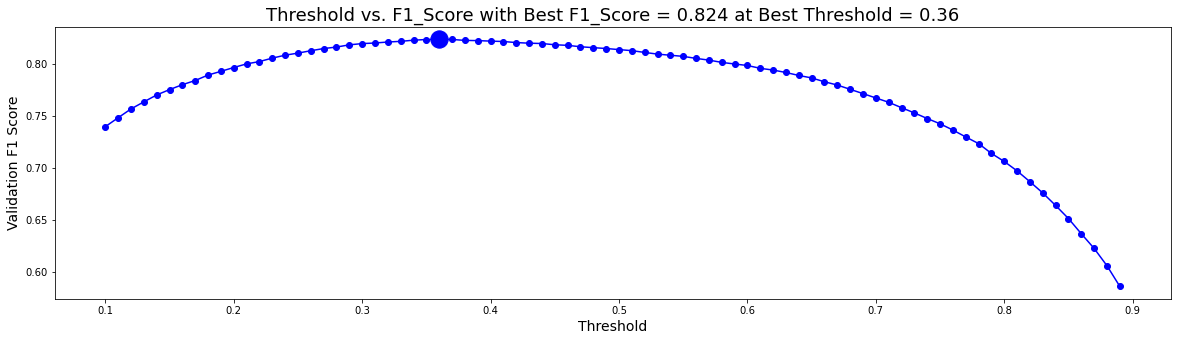

In [29]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [30]:
auc = roc_auc_score(y, train_pred['lgb'])
f1 = best_score
print((auc + f1) / 2)

0.902107571830407


# 生成提交结果

这里我们控制1的个数为4100个左右，最终线上得分0.7956687074375137，f1:0.6540415704387991, auc:0.9372958444362285。

In [52]:
# label=[1 if x >= 0.265+0.235 else 0 for x in prediction+0.235]
# np.sum(label)

label=[1 if x >= 0.26+0.24 else 0 for x in prediction+0.24]
np.sum(label)

4066

In [32]:
# preliminary_a_submit_sample['related_prob'] = prediction+0.24

In [53]:
preliminary_a_submit_sample.to_csv('./submission/submission30_2.csv', index=False)

# 进一步优化

1. 由于foodid只有训练集有，那么是否可以使用food侧的特征，做相似度模型，例如共现矩阵、tfidf、embedding等。

2. 目标编码做了之后，线下会涨很多但是线上长得比较少，还是过拟合比较严重，是否可以考虑根据疾病特征做聚类，然后减轻这种情况。同理food侧特征也可以做聚类，用来解决测试集都是训练集未曾出现过的id的问题。

3. 交叉特征里面，对于food侧只取了一部分，是否可以多取一点（进一步上述base可以通过筛选food特征提升至7976的分数，但是会很抖）。

4. 特征筛选的地方，并没有剔除缺失率高的特征，也没有根据对抗验证进行筛选，或许可以进行尝试。

5. 模型训练的参数，学习率太低，叶子节点数太高，导致模型过拟合比较严重，可以考虑调参（可以上分）。

6. 目前仅使用了lightgbm模型，可以考虑xgboost，catboost模型，进行模型的集成（xgb貌似还不错，需要祖传参数）。

7. 上述base是1的个数为4100个，可以调整不同的个数来测试，亲测不同的特征组合哪怕只是添加一个，最优的1的个数都是不同的。米哥开源的7949的代码，只需调整1的个数就可以7956，可以考虑将两份base结合看是否可以得到更高的分数。

8. svd的维度是可以调整的，不一定每个都是一样的。以及还可以使用pca的方法，不过需要进行归一化。